<a href="https://colab.research.google.com/github/mskbasha/Sentiment_analyis/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
import torch 
import math
import keras 
import pandas as pd 
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from sklearn.metrics import f1_score
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding,Dense,MultiHeadAttention,Input,LayerNormalization,Flatten

# Reading Data

In [ ]:
from progressbar import progressbar
import time 
pb = progressbar(0.1,30,'#','')
for i in range(100):
    time.sleep(0.1)
    pb.print(i,100,error =i**2 )

[                              ] 
 
[                              ] 
 
[#                             ] 
 
[#                             ] 
 
[#                             ] 
 
[##                            ] 
 
[##                            ] 
 
[##                            ] 
 
[##                            ] 
 
[###                           ] 
 
[###                           ] 
 
[###                           ] 
 
[####                          ] 
 
[####                          ] 
 
[####                          ] 
 
[####                          ] 
 
[#####                         ] 
 
[#####                         ] 
 
[#####                         ] 
 
[######                        ] 
 
[######                        ] 
 
[######                        ] 
 
[#######                       ] 
 
[#######                       ] 
 
[#######                       ] 
 
[########                      ] 
 
[########                      ] 
 
[########                   

In [ ]:
from zipfile import ZipFile
with ZipFile("/content/drive/MyDrive/Chrome OS/Coding data/archive.zip",'r') as f:
    f.extractall()

In [ ]:
data = pd.read_csv("/content/train.csv",encoding='ISO-8859-1')

In [ ]:
data.head(4)

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164


In [ ]:
data = data.dropna()

In [ ]:
unique_chars = set(' '.join(data.text.dropna()))

<Axes: ylabel='Frequency'>

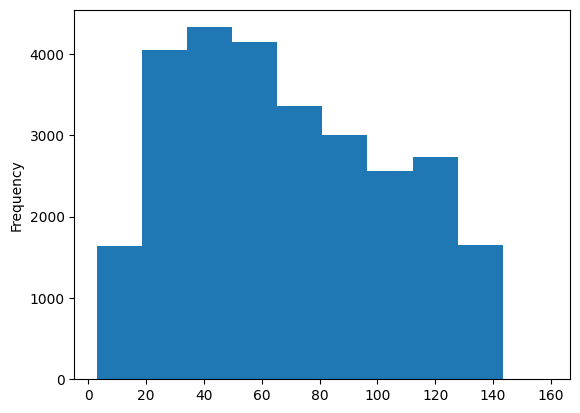

In [ ]:
data.text.apply(lambda x:len(x)).plot.hist()

In [ ]:
chars = {char:ind+1 for ind,char in enumerate(unique_chars)}
index = {ind+1:char for ind,char in enumerate(unique_chars)}

data['embeddings'] = data.text.fillna('').apply(lambda x:[chars[i] for i in x])

In [ ]:
padded_sequences = pad_sequences(data['embeddings'], maxlen=100, padding='post', truncating='post')

In [ ]:
padded_sequences.shape

(27480, 100)

((27480, 100), (27480,))

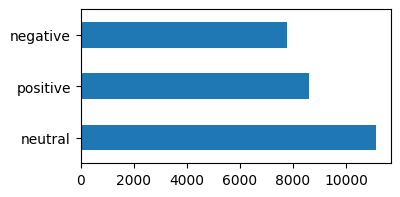

In [ ]:
data.sentiment.value_counts().plot.barh(figsize = (4,2))
padded_sequences.shape,data.sentiment.shape

In [ ]:
y = pd.get_dummies(data.sentiment)
x = padded_sequences
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25)

In [ ]:
x.shape,y.shape

((27480, 100), (27480, 3))

In [ ]:
len(unique_chars)

103

In [ ]:
!pip install keras_nlp --quiet

In [ ]:
x_train.shape

(20610, 100)

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Embedding, Dense, MultiHeadAttention, LayerNormalization, Flatten,GlobalMaxPooling1D
import keras_nlp
text_size = 100
embedding_size = 500
inputlayer = Input(shape=(text_size,))
output = Embedding(len(unique_chars) + 1, embedding_size, mask_zero=True)(inputlayer)
output = keras_nlp.layers.PositionEmbedding(
    embedding_size, initializer="glorot_uniform"
)(output)
for i in range(50):
  output = keras_nlp.layers.TransformerEncoder(
      intermediate_dim=1000, num_heads=8)(output)
output = GlobalMaxPooling1D()(output) 
output = Dense(3,activation='softmax')(output)

model = keras.models.Model(inputs=inputlayer, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

In [ ]:
model.fit(x_train,y_train,epochs=10)

In [ ]:
np.argmax(y_test.values,axis=1)

array([[0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       ...,
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0]], dtype=uint8)

In [ ]:
y_pred = np.argmax(model.predict(x_test),axis=1)
f1_score(y_pred,np.argmax(y_test.values,axis=1),average='macro')

215/215 [==============================] - 6s 30ms/step


0.18933472294597883

In [ ]:
dx_train = torch.tensor(x_train)
y_train = torch.tensor(y_train.to_numpy())
y_train = torch.argmax(y_train,axis=1)

In [ ]:
x_test = torch.tensor(x_test)
y_test = torch.tensor(y_test.to_numpy())
y_test = torch.argmax(y_test,axis=1)

In [ ]:
class PositionalEncoding(torch.nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)
class EncoderBlock(torch.nn.Module):
    def __init__(self,no_heads,seq_length,Embedding_dim):
        super().__init__()
        assert Embedding_dim%no_heads ==0
        self.FF = torch.nn.Linear(Embedding_dim,Embedding_dim,bias = False)
        self.MHA = torch.nn.MultiheadAttention(Embedding_dim,no_heads,dropout=0.01,batch_first=True)
        self.ffn = torch.nn.Sequential(
            torch.nn.Linear(Embedding_dim, int(1.5*Embedding_dim)),
            torch.nn.ReLU(inplace=False),
            torch.nn.Linear(int(1.5*Embedding_dim), Embedding_dim)
        )
        self.normE = torch.nn.LayerNorm(Embedding_dim)
        self.normF = torch.nn.LayerNorm(Embedding_dim)
        self.PE = PositionalEncoding(Embedding_dim)
    def forward(self,x,key_padding_mask=None,attn_mask=None):
        x = self.PE(x.permute(1,0,2))
        x = x.permute(1,0,2)
        q = self.FF(x)
        k = self.FF(x)
        v = self.FF(x)
        output = self.MHA(q,k,v,key_padding_mask,attn_mask)[0]+x
        output1 = self.normE(output)
        output = self.ffn(output1)
        output = output+output1
        output = self.normF(output)
        return output
class Encoder(torch.nn.Module):
    def __init__(self,no_blocks,no_heads,seq_length,Embedding_dim,unique_chars):
        super().__init__()
        self.Emb = torch.nn.Embedding(len(unique_chars)+1,embedding_dim=Embedding_dim,padding_idx=0)
        self.blocks = torch.nn.ModuleList([EncoderBlock(no_heads,seq_length,Embedding_dim) for _ in range(no_blocks)])
        self.Flatten = torch.nn.Flatten()
        self.linear = torch.nn.Linear(Embedding_dim*seq_length,3,bias=True)
    def forward(self,x):
        mask = (x==0)
        x = self.Emb(x)
        for block in self.blocks:
            x = block(x,mask)
        x = self.Flatten(x)
        return self.linear(x)
model = Encoder(30,10,100,130,unique_chars)

In [ ]:
x_train.shape

torch.Size([20610, 100])

In [ ]:
from prettytable import PrettyTable
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: 
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
count_parameters(model)

+-------------------------------+------------+
|            Modules            | Parameters |
+-------------------------------+------------+
|           Emb.weight          |   13520    |
|       blocks.0.FF.weight      |   16900    |
|  blocks.0.MHA.in_proj_weight  |   50700    |
|   blocks.0.MHA.in_proj_bias   |    390     |
|  blocks.0.MHA.out_proj.weight |   16900    |
|   blocks.0.MHA.out_proj.bias  |    130     |
|     blocks.0.ffn.0.weight     |   25350    |
|      blocks.0.ffn.0.bias      |    195     |
|     blocks.0.ffn.2.weight     |   25350    |
|      blocks.0.ffn.2.bias      |    130     |
|     blocks.0.normE.weight     |    130     |
|      blocks.0.normE.bias      |    130     |
|     blocks.0.normF.weight     |    130     |
|      blocks.0.normF.bias      |    130     |
|       blocks.1.FF.weight      |   16900    |
|  blocks.1.MHA.in_proj_weight  |   50700    |
|   blocks.1.MHA.in_proj_bias   |    390     |
|  blocks.1.MHA.out_proj.weight |   16900    |
|   blocks.1.

4149473

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
train = TensorDataset(x_train, y_train)
test =  TensorDataset(x_test, y_test)
batch_size = 32
train_dataset, test_dataset = DataLoader(train,batch_size=batch_size, shuffle=True),DataLoader(test,batch_size=batch_size, shuffle=True)


In [ ]:
model.to('cuda')

Encoder(
  (Emb): Embedding(104, 130, padding_idx=0)
  (blocks): ModuleList(
    (0-29): 30 x EncoderBlock(
      (FF): Linear(in_features=130, out_features=130, bias=False)
      (MHA): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=130, out_features=130, bias=True)
      )
      (ffn): Sequential(
        (0): Linear(in_features=130, out_features=195, bias=True)
        (1): ReLU()
        (2): Linear(in_features=195, out_features=130, bias=True)
      )
      (normE): LayerNorm((130,), eps=1e-05, elementwise_affine=True)
      (normF): LayerNorm((130,), eps=1e-05, elementwise_affine=True)
      (PE): PositionalEncoding(
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (Flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=13000, out_features=3, bias=True)
)

In [ ]:
def predict(test_dataset,batch_size):
    y_pred = []
    y_true = []
    with torch.no_grad():
        for inputs,labels in test_dataset:
            inputs = inputs.cuda()
            y_pred.append(torch.argmax(model(inputs),axis=1))
            y_true.append(labels)
        y_pred,y_true = torch.cat(y_pred),torch.cat(y_true)
        return f1_score(y_true.cpu(),y_pred.cpu(),average='macro')
predict(test_dataset,32)

0.23173182373182374

In [ ]:
from progressbar import progressbar
pb = progressbar(1)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
full_loss = 0
with torch.autograd.set_detect_anomaly(True):
    for epoch in range(10):
        score = predict(test_dataset,32)   
        for i,(inputs,labels) in enumerate(train_dataset):
            optimizer.zero_grad()
            inputs = inputs.cuda()
            labels = labels.cuda()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            full_loss+=loss.item()
            pb.print(i,644,f"\n {round(loss.item(),2)} for {epoch} epoch f1score = {round(score,2)}")

[--------------------------------------------------------------->.....................................] 
 
 1.08 for 0 epoch f1score = 0.23


In [ ]:
model.to('cuda')

Encoder(
  (Emb): Embedding(104, 100, padding_idx=0)
  (blocks): ModuleList(
    (0-9): 10 x EncoderBlock(
      (FF): Linear(in_features=100, out_features=100, bias=False)
      (MHA): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
      )
      (ffn): Sequential(
        (0): Linear(in_features=100, out_features=150, bias=True)
        (1): ReLU()
        (2): Linear(in_features=150, out_features=100, bias=True)
      )
      (normE): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
      (normF): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
    )
  )
  (Flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=10000, out_features=3, bias=True)
)

In [ ]:
def predict(batch_size):
    y_pred = []
    y_true = []
    with torch.no_grad():
        for inputs,labels in test_dataset:
            inputs = inputs.cuda()
            y_pred.append(torch.argmax(model(inputs),axis=1))
            y_true.append(labels)
        y_pred,y_true = torch.cat(y_pred),torch.cat(y_true)
        return f1_score(y_true.cpu(),y_pred.cpu(),average='macro')
predict(32)

0.2994561417260664

0.29993168739944576

In [ ]:
# Example of target with class indices
loss = nn.CrossEntropyLoss()
input = torch.tensor([[ 0.8592,  0.3960,  0.3329,  0.5369,  0.4732],
         [-1.9554, -0.3758,  0.9111,  0.4702, -1.3886],
         [-1.8866, -1.0000,  1.0224,  0.0056,  0.1627]])
target = torch.tensor([4,3,4])
output = loss(input, target)
input,target,output

(tensor([[ 0.8592,  0.3960,  0.3329,  0.5369,  0.4732],
         [-1.9554, -0.3758,  0.9111,  0.4702, -1.3886],
         [-1.8866, -1.0000,  1.0224,  0.0056,  0.1627]]),
 tensor([4, 3, 4]),
 tensor(1.4614))

In [ ]:
k = 0
l = 4,3,4
for ind,i in enumerate(torch.nn.functional.softmax(input,dim=1)):
    k+=math.log(i[l[ind]])
k

-4.384077237228478

In [ ]:
import torch
import torch.nn as nn
import math

loss = nn.CrossEntropyLoss()

# Predicted class scores (logits)
input = torch.tensor([[0.8592, 0.3960, 0.3329, 0.5369, 0.4732],
                     [-1.9554, -0.3758, 0.9111, 0.4702, -1.3886],
                     [-1.8866, -1.0000, 1.0224, 0.0056, 0.1627]])

# Target class labels
target = torch.tensor([4, 3, 4])

# Calculate the softmax probabilities
probabilities = torch.softmax(input, dim=1)

# Calculate the manually computed loss
manually_computed_loss = -torch.log(probabilities[range(len(target)), target]).sum()

# Calculate the loss using CrossEntropyLoss
output = loss(input, target)

print("Manually computed loss:", manually_computed_loss)
print("Loss using CrossEntropyLoss:", output)


Manually computed loss: tensor(4.3841)
Loss using CrossEntropyLoss: tensor(1.4614)


In [ ]:
k = torch.tensor([[
    [1,2,0],
    [3,0,5],
    [6,0,1],
    [0,1,2],
],
[
    [1,2,0],
    [3,0,5],
    [6,0,1],
    [0,1,2],
]])
torch.cat([k[0,:,:],k[1,:,:]],dim=1)

tensor([[1, 2, 0, 1, 2, 0],
        [3, 0, 5, 3, 0, 5],
        [6, 0, 1, 6, 0, 1],
        [0, 1, 2, 0, 1, 2]])

In [ ]:
torch.normal(0,1,size=(4,3,3,3)).masked_fill(k[:,None,None,:]==0,float('-inf')).shape

torch.Size([4, 3, 3, 3])

In [ ]:
torch.matmul(torch.normal(0,1,size=(10,5,10,10)),torch.normal(0,1,size = (10,5,10,5))).shape

torch.Size([10, 5, 10, 5])

In [ ]:
torch.tensor([[1,2,3],[3,4,5]])

tensor([[1, 2, 3],
        [3, 4, 5]])

In [ ]:
torch.tensor([[1,2,3],[3,4,5]]).reshape(3,2)

tensor([[1, 2],
        [3, 3],
        [4, 5]])

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import MultiHeadAttention,LayerNormalization,Dense
import tensorflow as tf

def encoder_block(input_tensor,emb_dim,num_heads):
    q, k, v= Dense(emb_dim)(input_tensor), Dense(emb_dim)(input_tensor), Dense(emb_dim)(input_tensor)
    output = MultiHeadAttention(num_heads=num_heads, key_dim=emb_dim)(q,k,v)
    output = LayerNormalization()(output)
    res = input_tensor+output
    output = Dense(emb_dim)(res)
    output = output+res
    return q,k,v,output
input_tensor = tf.keras.layers.Input((5,12))
output = input_tensor
for i in range(10): 
    q,k,v, output = encoder_block(output,12,2)

model = keras.Model(inputs=input_tensor, outputs=output)

In [ ]:
k = tf.random.normal((10,5,12),0,1)
model.predict(k).shapex

1/1 [==============================] - 2s 2s/step


(10, 5, 12)

In [ ]:
import keras
keras.layers.Dense(1)(tf.random.normal((10,10,),0,1)).shape

TensorShape([10, 1])